In [1]:
import wandb
import pandas as pd
import pickle
import seaborn as sns 
import functools
import operator 

In [2]:
def read_wandb_csv(loc):
    df = pd.read_csv(loc)
    df.param_config_id = df.param_config_id.astype('str')
    return df

id_df = read_wandb_csv("data/A_3_dropout_rate_test.csv")
id_df

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,ID,Group,...,test_f1_best_eval_loss,test_f1_best_f1,train_loss,train_p_max,train_p_var,train_st1_loss,train_st1_p_max,train_st2_loss,train_st2_p_max,vector_norms
0,26_S2_ID_20_MOD,running,-,ricu,"SWP2, modded, redo",2024-01-14T19:18:48.000Z,34,NaN,stj6elgc,NaN,...,NaN,NaN,NaN,NaN,NaN,0.728346,0.582575,0.733226,0.596697,"{""bins"":[0.00008087981404969469,0.015186947770..."
1,26_S2_ID_19_MOD,finished,-,ricu,"SWP2, modded, redo",2024-01-14T19:13:24.000Z,298,NaN,x2n74xh7,NaN,...,NaN,NaN,NaN,NaN,NaN,0.003895,0.996192,0.318314,0.971027,"{""bins"":[0.0000010672355301721836,0.0439419373..."
2,26_S2_ID_18_MOD,finished,-,ricu,"SWP2, modded, redo",2024-01-14T19:08:07.000Z,294,NaN,o7b9c653,NaN,...,NaN,NaN,NaN,NaN,NaN,0.004277,0.995734,0.322176,0.976498,"{""bins"":[0.00001015185898722848,0.043930832296..."
3,26_S2_ID_17_MOD,finished,-,ricu,"SWP2, modded, redo",2024-01-14T19:02:52.000Z,288,NaN,4x9ug8ek,NaN,...,NaN,NaN,NaN,NaN,NaN,0.001459,0.998575,0.013331,0.996122,"{""_type"":""histogram"",""bins"":[8.580915391576127..."
4,26_S2_ID_16_MOD,finished,-,ricu,"SWP2, modded, redo",2024-01-14T18:57:38.000Z,291,NaN,nsbp2900,NaN,...,NaN,NaN,NaN,NaN,NaN,0.001626,0.998378,0.029052,0.990561,"{""_type"":""histogram"",""bins"":[8.723092719264969..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,26_S0_ID_04_MOD,finished,-,ricu,"SWP0, modded, redo",2024-01-14T10:58:08.000Z,504,NaN,j966p6n3,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000568,0.999433,0.000978,0.999026,"{""_type"":""histogram"",""bins"":[7.189738084889541..."
71,26_S0_ID_03_MOD,finished,-,ricu,"SWP0, modded, redo",2024-01-14T10:49:29.000Z,495,NaN,fxgbb1l7,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000702,0.999298,0.000925,0.999076,"{""bins"":[0.0000010804799330799142,0.0002208250..."
72,26_S0_ID_02_MOD,finished,-,ricu,"SWP0, modded, redo",2024-01-14T10:40:41.000Z,505,NaN,qqj4n1lz,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000236,0.999764,0.000384,0.999616,"{""values"":[360,126,17,4,4,0,0,0,0,0,0,0,0,0,0,..."
73,26_S0_ID_01_MOD,finished,-,ricu,"SWP0, modded, redo",2024-01-14T10:32:09.000Z,490,NaN,84qize3s,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000526,0.999474,0.000747,0.999253,"{""_type"":""histogram"",""bins"":[8.481002851112862..."


In [3]:
from tqdm import tqdm
run_ids = id_df["ID"]

api = wandb.Api()

all_dfs = []
metrics_train = ["train_st2_loss"]
metrics_eval = ["accuracy","eval_loss","eval_p_max"]
metrics_lr = ["learning_rate"]
index_keys = ["_step","epoch"]

# Add tqdm to the loop for progress bar
for run_id in tqdm(run_ids):
    run = api.run(f"ricu/fantastic-umbrella/{run_id}")
    
    # Fetch the history
    history_train = run.scan_history(keys=metrics_train+index_keys)
    df_run =  pd.DataFrame([row for row in history_train])
    
    history_eval = run.scan_history(keys=metrics_eval+index_keys)
    df_run = df_run.merge(pd.DataFrame([row for row in history_eval]), on=['_step', 'epoch'], how='outer')
    
    history_lr = run.scan_history(keys=metrics_lr+index_keys)
    df_run = df_run.merge(pd.DataFrame([row for row in history_lr]), on=['_step', 'epoch'], how='outer')
    df_run = df_run.sort_values(by="_step", ascending=True,ignore_index=True)
    # last_step_diff = df_run["_step"].iloc[-1] - df_run["_step"].iloc[-2]
    # first_step_diff = df_run["_step"].iloc[1] - df_run["_step"].iloc[0]
    # if last_step_diff != first_step_diff:
    #     df_run.at[df_run.index[-1], 'train_st2_loss'] = df_run['train_st2_loss'].iloc[-1] / last_step_diff
    df_run["learning_rate"] = df_run["learning_rate"].fillna(0)

    for key, value in run.config.items():
        df_run = df_run.assign(**{key: value})
    
    all_dfs.append(df_run)

df = pd.concat(all_dfs,axis=0,ignore_index=True)
df["mode"] = df["catch_dropout"].fillna(1).map({0: 'FUMBRELLA', 1: 'VANILLA'})
with open("data/A_3_dropout.pkl",'wb') as f:
    pickle.dump(df,f)

100%|██████████| 75/75 [04:25<00:00,  3.54s/it]


In [4]:
with open("data/A_3_dropout.pkl",'rb') as f:
    df = pickle.load(f)
df.head()

,train_st2_loss,_step,epoch,accuracy,eval_loss,eval_p_max,learning_rate,seed,beta1,beta2,...,lr_scheduler_type,pad_to_max_length,model_name_or_path,warmup_steps_fraction,early_stopping_patience,ignore_mismatched_sizes,early_stopping_min_delta,per_device_eval_batch_size,per_device_train_batch_size,mode
0,NaN,0,-1,0.453613,0.806656,0.662279,0.00003,3,0.9,0.999,...,linear,False,bert-base-uncased,0.1,800,False,0,128,32,FUMBRELLA
1,0.733226,64,1,0.641602,0.653317,0.561615,0.00003,3,0.9,0.999,...,linear,False,bert-base-uncased,0.1,800,False,0,128,32,FUMBRELLA
2,0.627222,128,3,0.766113,0.523817,0.811500,0.00003,3,0.9,0.999,...,linear,False,bert-base-uncased,0.1,800,False,0,128,32,FUMBRELLA
3,0.571085,192,5,0.785156,0.557106,0.906115,0.00003,3,0.9,0.999,...,linear,False,bert-base-uncased,0.1,800,False,0,128,32,FUMBRELLA
4,0.638743,256,7,0.751465,0.832596,0.955259,0.00003,3,0.9,0.999,...,linear,False,bert-base-uncased,0.1,800,False,0,128,32,FUMBRELLA


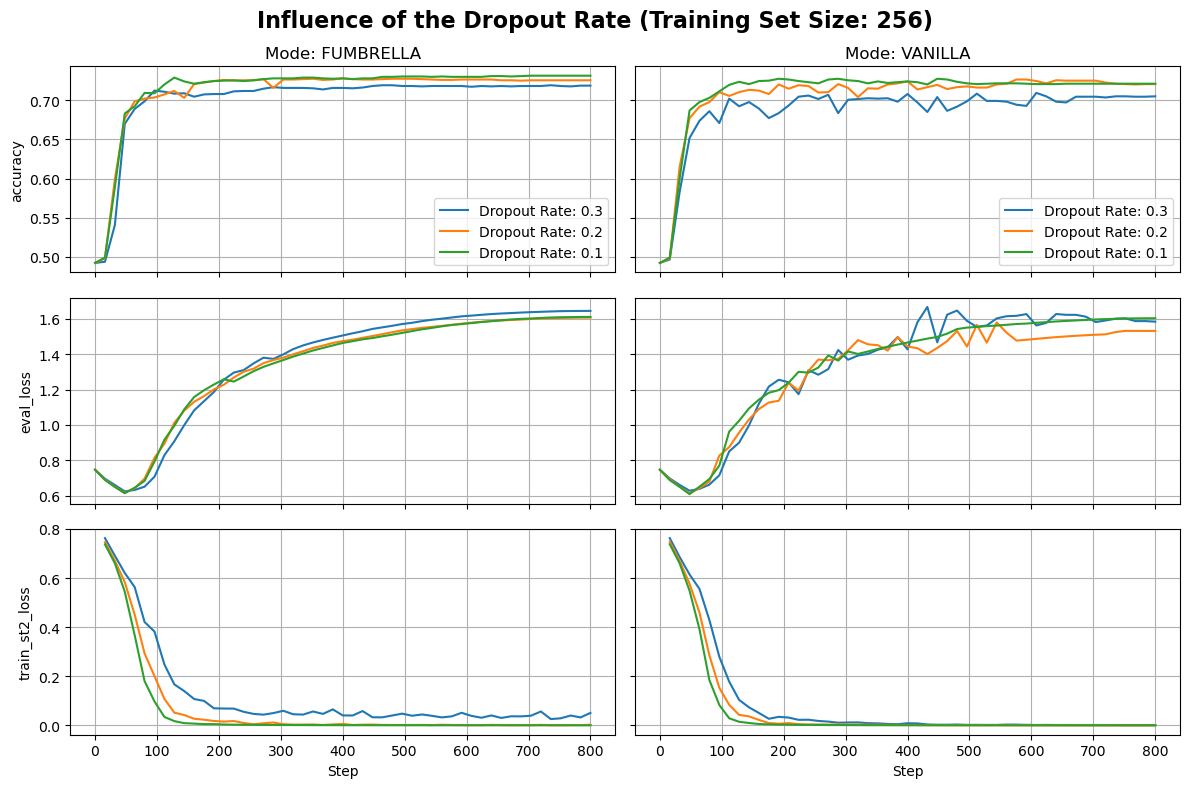

In [5]:
import matplotlib.pyplot as plt
selected_rows = functools.reduce(
    operator.and_,
    [
        df["training_size"] == 256
        # df["Tags"].str.contains('modded')
    ]  
    )
filtered_df = df.loc[selected_rows]

subplot_columns = sorted(df["mode"].unique())
subplot_rows = ['accuracy', 'eval_loss', 'train_st2_loss']
n_rows = len(subplot_rows)
n_cols = len(subplot_columns)
# Create a new figure
fig, axs = plt.subplots(
    n_rows,
    n_cols,
    sharex=True,
    sharey='row',
    figsize = (4*n_rows,4*n_cols)
    )

for idy, col_val in enumerate(subplot_columns):
    for idx, row_val in enumerate(subplot_rows):
        grouped_df = filtered_df.loc[df["mode"]==col_val].groupby(["insert_dropout","_step"])
        statistics = grouped_df[row_val].agg(['mean', 'median', 'std'])
        statistics = statistics.sort_index(level='insert_dropout', ascending=False)

        for dropout_rate in statistics.index.get_level_values('insert_dropout').unique():
            lr_stats = statistics.loc[dropout_rate]
            axs[idx,idy].plot(lr_stats.index, lr_stats["median"], label=f'Dropout Rate: {dropout_rate}')

        if idy == 0:
            axs[idx,idy].set_ylabel(row_val)
        if idx == 0:
            axs[idx,idy].set_title(f'Mode: {col_val}')
        if idx == len(subplot_rows) - 1:
            axs[idx,idy].set_xlabel('Step')

        axs[idx,idy].grid(True,which='major')
        axs[idx,idy].grid(True,which='minor')

        if idx == 0:
            axs[idx,idy].legend()


fig.suptitle('Influence of the Dropout Rate (Training Set Size: 256)', fontsize=16,weight='bold')
# Show the plot
plt.tight_layout()
plt.savefig('img/A_3_dropout.pdf', format='pdf')
plt.show()